In [1]:
import pandas as pd
import numpy as np
from utils.connect import GetQuery
from tqdm import tqdm

In [2]:
# Get filtered tickers
filtered = pd.read_csv("./list_ranked.csv")
filtered

,Unnamed: 0,symbol,type
0,0,QSR,common stock
1,1,GHC,common stock
2,2,MARA,common stock
3,3,GH,common stock
4,4,KW,common stock
...,...,...,...
6002,6002,CRO.CC,crypto
6003,6003,CRV.CC,crypto
6004,6004,EGLD.CC,crypto
6005,6005,EOS.CC,crypto


In [3]:
GetQuery(f"""
SELECT profile_id, risk_score
FROM profile_scoring_settings
""")

,profile_id,risk_score
0,253,1.0
1,21225,2.0
2,1414,2.0
3,20685,2.0
4,1457,2.0
...,...,...
13333,21757,2.0
13334,21729,2.0
13335,21730,3.0
13336,21731,2.0


In [4]:
# Get all users
df = GetQuery(f"""
SELECT profile_id, symbol, match_score, risk_similarity, interest_similarity, category_similarity
FROM gainy_analytics.profile_ticker_match_score
WHERE updated_at > now() - interval '1 week'
AND fits_risk IS NOT null
AND symbol IN {tuple(filtered.symbol)}
AND profile_id IN (253,20685, 21730 )
""")

In [5]:
df

,profile_id,symbol,match_score,risk_similarity,interest_similarity,category_similarity
0,253,1INCH.CC,9,0.595085,0.0,0.000000
1,253,A,62,0.923729,0.0,0.902737
2,253,AA,46,0.417966,0.0,0.690276
3,253,AAC,30,0.976441,0.0,0.000000
4,253,AADI,26,0.769746,0.0,0.000000
...,...,...,...,...,...,...
16921,21730,ZVIA,58,0.901864,0.0,0.810959
16922,21730,ZWRK,38,0.476441,0.0,0.496843
16923,21730,ZWS,30,0.665000,0.0,0.224893
16924,21730,ZYME,94,0.979661,1.0,0.844991


In [6]:
def sigmoid(x, beta):
    y = 1 / (1 + ((x+1e-10)/(1- x+1e-10))**(-beta))
    return (y)


In [7]:
x = np.linspace(0,1,100)
y = sigmoid(x, 1.5)

In [8]:
import matplotlib.pyplot as plt

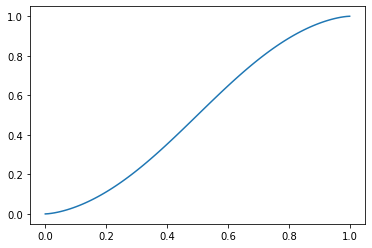

In [9]:
plt.plot(x,y)

In [10]:
def MatchScoreSigma(risk, interest, categories, weight=[0.6,0.3,0.1]):
    weighted_similarity = np.sum(np.array([risk, interest, categories]) * np.array(weight))
    
    return round(sigmoid(weighted_similarity,2)*100,0)
    

In [11]:
def MatchScoreRaw(risk, interest, categories, weight=[0.6,0.3,0.1]):
    weighted_similarity = np.sum(np.array([risk, interest, categories]) * np.array(weight))
    
    return round(weighted_similarity*100,0)

In [12]:
def MatchScoreSigmaWithin(risk, interest, categories, weight=[0.6,0.3,0.1], beta = 3):
    risk = sigmoid(risk, beta)
    interest = sigmoid(interest, beta)
    categories = sigmoid(categories, beta)
    weighted_similarity = np.sum(np.array([risk, interest, categories]) * np.array(weight))
    
    return round(weighted_similarity*100,0)

In [13]:
n = df.shape[0]

test = pd.DataFrame(np.empty((n,8)),
                    columns=['profile_id', 'risk_similarity',
                             'interest_similarity', 'category_similarity',
                             'old_match_score', 'linear_match_score', 'sigmoid_match_score', 'sigma_within'
                            ],
                   index = range(n))
for i in tqdm(range(n)):
    test['profile_id'].iloc[i] = df['profile_id'].iloc[i]
    test['risk_similarity'].iloc[i] = df['risk_similarity'].iloc[i]
    test['interest_similarity'].iloc[i] = df['interest_similarity'].iloc[i]
    test['category_similarity'].iloc[i] = df['category_similarity'].iloc[i]
    test['old_match_score'].iloc[i] = df['match_score'].iloc[i]
    test['linear_match_score'].iloc[i] = MatchScoreRaw(df.risk_similarity[i], df.interest_similarity[i], df.category_similarity[i], weight=[0.6,0.3,0.1])
    test['sigmoid_match_score'].iloc[i] = MatchScoreSigma(df.risk_similarity[i], df.interest_similarity[i], df.category_similarity[i], weight=[0.6,0.3,0.1])
    test['sigma_within'].iloc[i] = MatchScoreSigmaWithin(df.risk_similarity[i], df.interest_similarity[i], df.category_similarity[i], weight=[0.6,0.3,0.1])
    

100%|███████████████████████████████████| 16926/16926 [00:05<00:00, 2887.69it/s]


In [14]:
test

,profile_id,risk_similarity,interest_similarity,category_similarity,old_match_score,linear_match_score,sigmoid_match_score,sigma_within
0,253.0,0.595085,0.0,0.000000,9.0,36.0,24.0,46.0
1,253.0,0.923729,0.0,0.902737,62.0,64.0,77.0,70.0
2,253.0,0.417966,0.0,0.690276,46.0,32.0,18.0,25.0
3,253.0,0.976441,0.0,0.000000,30.0,59.0,67.0,60.0
4,253.0,0.769746,0.0,0.000000,26.0,46.0,42.0,58.0
...,...,...,...,...,...,...,...,...
16921,21730.0,0.901864,0.0,0.810959,58.0,62.0,73.0,70.0
16922,21730.0,0.476441,0.0,0.496843,38.0,34.0,20.0,31.0
16923,21730.0,0.665000,0.0,0.224893,30.0,42.0,35.0,53.0
16924,21730.0,0.979661,1.0,0.844991,94.0,97.0,100.0,100.0


<AxesSubplot:xlabel='risk_similarity'>

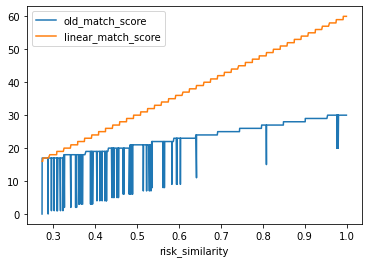

In [16]:
pid = test.profile_id.unique()[0]
test.loc[(test.profile_id==pid)&(test.category_similarity==0)&(test.interest_similarity==0)].sort_values('risk_similarity').set_index('risk_similarity')[['old_match_score','linear_match_score']].plot()

<AxesSubplot:xlabel='risk_similarity'>

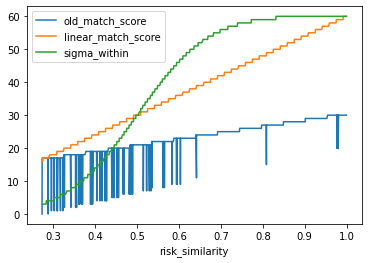

In [17]:
test.loc[(test.profile_id==pid)&(test.category_similarity==0)&(test.interest_similarity==0)].sort_values('risk_similarity').set_index('risk_similarity')[['old_match_score','linear_match_score','sigma_within']].plot()

<AxesSubplot:xlabel='risk_similarity'>

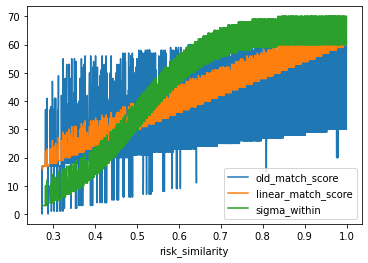

In [18]:
test.loc[(test.profile_id==pid)&(test.interest_similarity==0)].sort_values('risk_similarity').set_index('risk_similarity')[['old_match_score','linear_match_score','sigma_within']].plot()

<AxesSubplot:xlabel='risk_similarity'>

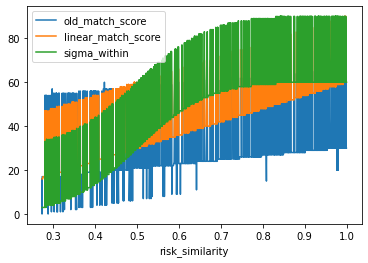

In [19]:
test.loc[(test.profile_id==pid)&(test.category_similarity==0)].sort_values('risk_similarity').set_index('risk_similarity')[['old_match_score','linear_match_score','sigma_within']].plot()

<AxesSubplot:xlabel='risk_similarity'>

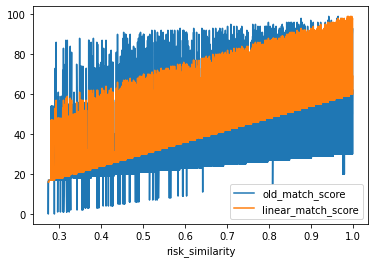

In [20]:

test.loc[test.profile_id==pid].sort_values('risk_similarity').set_index('risk_similarity')[['old_match_score','linear_match_score']].plot()

<AxesSubplot:xlabel='risk_similarity'>

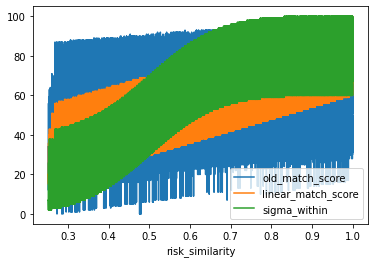

In [21]:
test.sort_values('risk_similarity').set_index('risk_similarity')[['old_match_score','linear_match_score', 'sigma_within']].plot()